# prototyping LSS pipeline

## setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os, pickle, time, glob, sys, copy
import numpy as np 
import scipy
import mdtraj as md 
import MDAnalysis as mda
import nglview as nv 
from ipywidgets import interactive, VBox
import sklearn.preprocessing as pre
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import pyemma as py 
from pyemma.util.contexts import settings
import warnings
warnings.filterwarnings('ignore')

/home/joseph/anaconda3/envs/lss/lib/python3.6/site-packages/Bio/KDTree/__init__.py:25: BiopythonDeprecationWarning: Bio.KDTree has been deprecated, and we intend to remove it in a future release of Biopython. Please use Bio.PDB.kdtrees instead, which is functionally very similar.
  BiopythonDeprecationWarning)
/home/joseph/anaconda3/envs/lss/lib/python3.6/site-packages/MDAnalysis/due.py:88: UserWarning: No module named 'duecredit'
  warnings.warn(str(err))


In [3]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1' 

In [4]:
import tensorflow as tf
import keras.backend as K
from keras.models import load_model
from keras.callbacks import EarlyStopping
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [5]:
import sys
#__all__ = ["hde", "propagator", "molgen"]
from hde import *#__init__, hde, propagator, molgen, analysis #

## locating trajectory data

In [6]:
# DESRES Chignolin at 340 K
# Lindorff-Larsen et al. Science 334 6055 517-520 (2011)
# 200 ps time steps
# 53 dcd files each conataining 10,000 frames at 200 ps time steps = 53*10,000*200 = 106 us

timestep = 200 # ps

pdb_dir = "/media/joseph/Memorex USB/liew/Joe_Liew_LSS/Joe_Liew_LSS/PRB/DESRES-Trajectory_PRB-0-protein/PRB-0-protein"
pdb_file = os.path.join(pdb_dir, "system.pdb")

trj_dir = pdb_dir
trj_file = []
for i in np.arange(0,15):
    fname = "PRB-0-protein-" + str(i).zfill(3) + ".dcd"
    trj_file.append(os.path.join(trj_dir, fname))
print(pdb_file)

print(pdb_file)
view = nv.show_structure_file(pdb_file)
view.clear_representations()
view.add_ball_and_stick()
view

/media/joseph/Memorex USB/liew/Joe_Liew_LSS/Joe_Liew_LSS/PRB/DESRES-Trajectory_PRB-0-protein/PRB-0-protein/system.pdb
/media/joseph/Memorex USB/liew/Joe_Liew_LSS/Joe_Liew_LSS/PRB/DESRES-Trajectory_PRB-0-protein/PRB-0-protein/system.pdb


NGLWidget()

### mdtraj load and view

In [7]:
traj_obj = md.load(trj_file, top=pdb_file)

In [8]:
traj_obj.center_coordinates(mass_weighted=False)
traj_obj.superpose(traj_obj[0])

<mdtraj.Trajectory with 150000 frames, 737 atoms, 47 residues, and unitcells at 0x7f84bc9737f0>

In [9]:
view = nv.show_mdtraj(traj_obj)
view.clear_representations()
view.add_spacefill()
view

NGLWidget(count=150000)

#### h2t

In [10]:
Ca_first_idx = traj_obj.topology.select('name CA and resid 0')
Ca_last_idx = traj_obj.topology.select('name CA and resid ' + str(traj_obj.n_residues-1))

In [11]:
h2t = md.compute_distances(traj_obj, np.reshape(np.array([Ca_first_idx, Ca_last_idx]), (1,2)), periodic=True, opt=True)

## featurization

In [12]:
# featurizing
features = py.coordinates.featurizer(pdb_file)
features.add_backbone_torsions(cossin=True)
features.add_sidechain_torsions(which='all', cossin=True)
atom_idx = features.select_Backbone() # select_Heavy() select_Ca()
features.add_inverse_distances(atom_idx)

#print(features.describe())
print('dim = %d' % features.dimension())

06-05-21 11:32:40 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  The 1D arrays input for add_inverse_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features
dim = 10224


/home/joseph/anaconda3/envs/lss/lib/python3.6/site-packages/mdtraj/geometry/dihedral.py:374: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(x for x in indices if x.size)[id_sort]
/home/joseph/anaconda3/envs/lss/lib/python3.6/site-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())


## (1) latent space projection

### parameters

In [13]:
lag=50
dim=4
is_reversible=True

### SRV

In [14]:
#earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)

hde = HDE(
    features.dimension(), 
    n_components=dim, 
    lag_time=lag,
    reversible=is_reversible, 
    n_epochs=300,
    learning_rate=0.0005,
    hidden_layer_depth=2,
    hidden_size=100,
    activation='tanh', 
    batch_size=20000,
    batch_normalization=True,
    #callbacks=[earlyStopping], 
    verbose=True
)

In [15]:
hde = pickle.load(open('hde.pkl', 'rb'))

/home/joseph/anaconda3/envs/lss/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [16]:
data = np.zeros((100000,2))
for i in range(len(trj_file)):
    print(100 * i / len(trj_file), "%")
    q = py.coordinates.load(trj_file[i], features=features, chunksize = 80)
    h = hde.transform(q, side="left")
    r = i*10000
    l = (i+1*10000)
    if(i == 0):
        data = h
    else:
        data = np.concatenate((data, h), axis = 0)

0.0 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

6.666666666666667 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

13.333333333333334 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

20.0 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

26.666666666666668 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

33.333333333333336 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

40.0 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

46.666666666666664 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

53.333333333333336 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

60.0 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

66.66666666666667 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

73.33333333333333 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

80.0 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

86.66666666666667 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

93.33333333333333 %


getting output of FeatureReader:   0%|          | 0/125 [00:00<?, ?it/s]

In [17]:
data.shape

(150000, 30)

In [18]:
hde_coords = data
hde_timescales = hde.timescales_
print(hde_timescales)
print(hde_coords)
print(hde.eigenvalues_)


[46420.79046473 13971.9101346  13468.11475378 12445.27641336
  8351.22106403  6811.8781488   6718.68179507  6512.12902145
  5637.78312515  5419.69815096  4553.30751855  4488.02977924
  4247.08664281  4017.63021589  3841.88580885  3701.59201492
  3573.92120154  3116.68769912  2774.0774663   2530.02048701
  2466.62353861  2377.50437182  2035.74513283  1982.47807373
  1974.87367968  1833.20831984  1687.43912992  1610.09088301
  1236.88317086   790.03179414]
[[ 0.20036936 -0.04233656  0.12649898 ...  0.15601103  0.313348
  -0.38842446]
 [ 0.2024201  -0.04642764  0.13606127 ...  0.15635458  0.30338266
  -0.40084797]
 [ 0.202884   -0.0481393   0.13431238 ...  0.14482361  0.3007402
  -0.3947372 ]
 ...
 [ 0.2774341  -0.09900649 -0.08507805 ...  0.09337604 -0.86989117
   0.27820683]
 [ 0.2756784  -0.06453228 -0.07109565 ...  0.47792283 -0.7198187
   0.02707868]
 [ 0.25957665 -0.05733718 -0.04939149 ...  0.6895888  -0.6946375
   0.2374748 ]]
[0.99784811 0.99286833 0.99260255 0.99199702 0.9880971

Text(0.5, 1.0, "$t_i$'s BBA")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


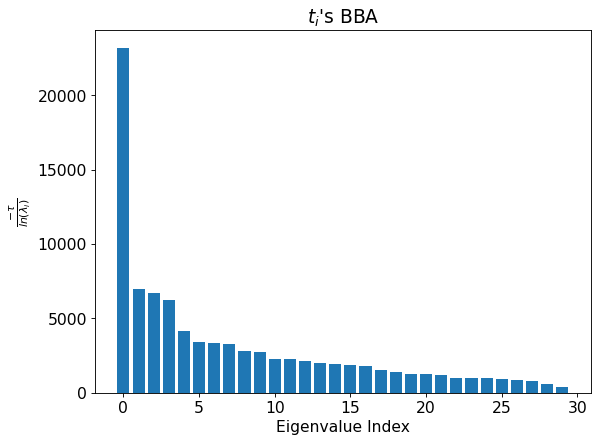

In [19]:
from matplotlib.pyplot import figure
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

heights = -lag/np.log(hde.eigenvalues_)
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.bar(range(len(heights)), heights)
plt.xlabel("Eigenvalue Index")
plt.ylabel(r'$\frac{-\tau}{ln(\lambda_i)}$')
plt.title(r"$t_i$'s BBA")

## (2) propagator

In [38]:
dim_prop = 30

In [39]:
traj_prop = copy.deepcopy(hde_coords[:,:dim_prop])

In [40]:
prop_scaler = pre.MinMaxScaler(feature_range=(0,1))
if dim_prop==1:
    traj_prop_scaled = prop_scaler.fit_transform(traj_prop.reshape(-1, 1))
else:
    traj_prop_scaled = prop_scaler.fit_transform(traj_prop)

In [41]:
n_mix = 25
lag_prop = lag
lr_prop = 0.0001

In [42]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)
]

In [43]:
prop = Propagator(
    traj_prop_scaled.shape[1], 
    n_components=n_mix, 
    lag_time=lag_prop, 
    batch_size=200000, 
    learning_rate=lr_prop, 
    n_epochs=20000,
    callbacks=callbacks,
    hidden_size=100,
    activation='relu'
)

In [44]:
from hde.propagator import get_mixture_loss_func

In [45]:
prop.model.compile(loss=get_mixture_loss_func(prop.input_dim, prop.n_components), optimizer=tf.keras.optimizers.Adam(lr=lr_prop))

In [46]:
prop.model.set_weights(pickle.load(open('prop_weights.pkl', 'rb')))

In [47]:
n_steps = np.int(np.floor(np.float(hde_coords.shape[0])/np.float(lag_prop)))
n_traj = 5
synth_trajs_scaled = [prop.propagate(traj_prop_scaled[0].reshape(1,-1).astype(np.float32), n_steps).reshape(n_steps, -1) for item in range(n_traj)]
synth_trajs = [prop_scaler.inverse_transform(synth_trajs_scaled[i]) for i in range(n_traj)]

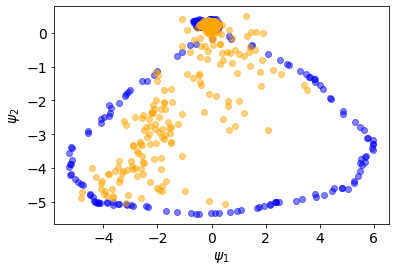

In [51]:
synth_traj_id = 0
fig, ax = plt.subplots()
id1 = 1
id2 = 0
if dim_prop==1:
    ax.scatter(hde_coords[::lag_prop,0], np.zeros(hde_coords[::lag_prop,id1].shape[0]), c='blue', alpha=0.5, cmap='jet')
    ax.scatter(synth_trajs[synth_traj_id][:,0], np.zeros(synth_trajs[synth_traj_id][:,0].shape[0]), c='orange', alpha=0.5, cmap='jet')
    ax.set_xlabel(r'$\psi_1$')
    ax.set_ylabel(r'$\psi_2$')
else:
    ax.scatter(hde_coords[::lag_prop,id1], hde_coords[::lag_prop,id2], c='blue', alpha=0.5, cmap='jet')
    ax.scatter(synth_trajs[synth_traj_id][:,id1], synth_trajs[synth_traj_id][:,id2], c='orange', alpha=0.5, cmap='jet')
    ax.set_xlabel(r'$\psi_1$')
    ax.set_ylabel(r'$\psi_2$')

plt.show()

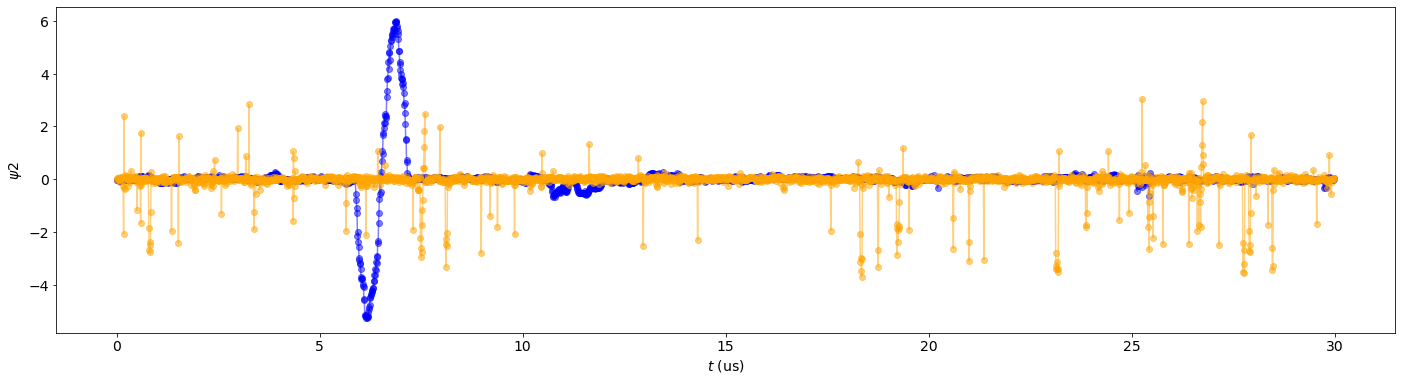

In [52]:
synth_traj_id = 1
psi_id = 1

fig, ax = plt.subplots(figsize=(24, 6))
ax.plot(np.arange(hde_coords[::lag_prop,psi_id].shape[0])*timestep/1E6*lag_prop, hde_coords[::lag_prop,psi_id], color='blue', alpha=0.5, marker='o')
ax.plot(np.arange(synth_trajs[synth_traj_id].shape[0])*timestep/1E6*lag_prop, synth_trajs[synth_traj_id][:,psi_id], color='orange', alpha=0.5, marker='o')
ax.set_xlabel(r'$t$ (us)')
ax.set_ylabel(r'$\psi$'+str(psi_id+1))
plt.show()

### (3) generator

#### x_train = scaled latent space coordinates

In [ ]:
x_train = traj_prop_scaled

#### y_train = aligned molecular configurations

In [ ]:
ca_idx = traj_obj.top.select_atom_indices('alpha')
traj_ca = traj_obj.atom_slice(ca_idx)

In [34]:
traj_ca.superpose(traj_ca[0])

<mdtraj.Trajectory with 100000 frames, 47 atoms, 47 residues, and unitcells at 0x7f9f20c3d550>

In [35]:
view = nv.show_mdtraj(traj_ca[::lag_prop])
#view.component_0.clear_representations()
view.component_0.add_ribbon(color='blue', opacity=0.6)
view
view

NGLWidget(count=2000)

In [36]:
xyz = traj_ca.xyz.reshape(-1, traj_ca.n_atoms*3)

In [37]:
xyz_scaler = pre.MinMaxScaler(feature_range=(-1,1))

In [38]:
y_train = xyz_scaler.fit_transform(xyz)

In [39]:
n_atoms = traj_ca.n_atoms

#### training cWGAN

In [40]:
molgen = MolGen(
    latent_dim=x_train.shape[1],
    output_dim=y_train.shape[1],
    batch_size=30000,
    noise_dim=50,
    n_epochs=2500,
    hidden_layer_depth=2,
    hidden_size=200,
    n_discriminator=5
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               16200     
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_6 (Dense)              (None, 141)               28341     
Total params: 84,741
Trainable params: 84,741
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 200)               34400     
_________________________________________________________________
dense_8 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_

In [41]:
def swish(x):
    return (K.sigmoid(x) * x)
molgen.generator = tf.keras.models.load_model('molgen_generator.h5', custom_objects={'swish': swish},compile=False)
molgen.discriminator = tf.keras.models.load_model('molgen_discriminator.h5', custom_objects={'swish': swish},compile=False)
molgen.is_fitted = True# need to override after loading to allow molgen.transform to proceed


#### decoding synthetic propagator trajectories

In [42]:
assert molgen.is_fitted == True
print(len(synth_trajs_scaled[synth_traj_id]))

2000


In [43]:
synth_traj_id = 1
xyz_synth = xyz_scaler.inverse_transform(molgen.transform(synth_trajs_scaled[synth_traj_id])).reshape(-1, n_atoms, 3)
xyz_synth

array([[[-0.09636348, -0.90873826,  0.90432984],
        [-0.01326219, -0.8188848 ,  0.703303  ],
        [ 0.03944521, -0.39386928,  0.85876215],
        ...,
        [ 0.8035103 ,  0.4943968 , -0.14758779],
        [ 0.9096816 ,  0.73277974, -0.1711825 ],
        [ 0.75878763,  0.95416534, -0.7075101 ]],

       [[-0.8688579 ,  0.0191886 ,  0.7550943 ],
        [-0.8558007 , -0.09068941,  0.72233117],
        [-0.78337604, -0.11404679,  0.728762  ],
        ...,
        [ 0.6397526 , -0.10860592, -1.0721693 ],
        [ 1.0696836 , -0.27444953, -1.1695557 ],
        [ 1.231732  , -0.0314476 , -1.1633874 ]],

       [[ 0.65468717,  0.953659  , -0.11483118],
        [-0.5459041 ,  1.3345231 ,  1.1105753 ],
        [ 0.586119  ,  0.7446585 ,  1.3426145 ],
        ...,
        [ 0.04505699,  1.8829284 ,  0.3207576 ],
        [ 1.0083076 ,  1.9202274 ,  0.29236475],
        [ 0.64233726,  1.887932  ,  0.8504699 ]],

       ...,

       [[-0.11213265,  1.128375  ,  1.3473632 ],
        [ 0

In [44]:
with open('synth.xyz', 'w') as f:
    for i in range(xyz_synth.shape[0]):
        f.write('%d\n' % n_atoms)
        f.write('\n')
        for k in range(n_atoms):
            f.write('%3s%17.9f%17.9f%17.9f\n' % ('C', xyz_synth[i][k][0]*10, xyz_synth[i][k][1]*10, xyz_synth[i][k][2]*10) ) # nm to Angstroms for xyz write

In [45]:
traj_ca[0].save_pdb('synth.pdb')

In [46]:
traj_ca_synth = copy.deepcopy(traj_ca)

In [47]:
traj_ca_synth

<mdtraj.Trajectory with 100000 frames, 47 atoms, 47 residues, and unitcells at 0x7f9f181999b0>

In [48]:
traj_synth_obj = md.load('synth.xyz', top='synth.pdb')

In [49]:
traj_synth_obj.center_coordinates(mass_weighted=False)
traj_synth_obj.superpose(traj_synth_obj[0])

<mdtraj.Trajectory with 2000 frames, 47 atoms, 47 residues, without unitcells at 0x7f9f181aed30>

In [50]:
view = nv.show_mdtraj(traj_synth_obj)
view

NGLWidget(count=2000)

## (4) comparison

### thermodynamics (FES)

1D PMF in leading SRV coordinate

adding one pseudo-count to each bin as regularization and avoiding infinite free energies


In [51]:
# MD 1D PMF mean
n_bins = 50
pdf_MD, bin_edges = np.histogram(hde_coords[:,0], bins=n_bins, density=True)
bin_mids = bin_edges[:-1]+0.5*(bin_edges[1]-bin_edges[0])

pdf_MD += 1./(len(hde_coords[:,0])*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
pmf_MD = -np.log(pdf_MD)
pmf_MD -= np.mean(pmf_MD[np.isfinite(pmf_MD)]) # optimal mutual least squares alignment

In [52]:
# MD 1D PMF block averages
pmf_MD_block = []
n_blocks=5
for i in range(n_blocks):
    
    data_i = np.array_split(hde_coords[:,0],n_blocks,axis=0)[i] #block splits
    
    pdf_MD_i, _ = np.histogram(data_i, bins=bin_edges, density=True)
    pdf_MD_i += 1./(len(data_i)*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
    
    pmf_MD_i = -np.log(pdf_MD_i)
    pmf_MD_i -= np.mean(pmf_MD_i[np.isfinite(pmf_MD_i)]) # optimal mutual least squares alignment
    pmf_MD_block.append(pmf_MD_i)
    
pmf_MD_block = np.array(pmf_MD_block)
pmf_MD_stderr = np.std(pmf_MD_block, axis=0)/np.sqrt(n_blocks)

In [53]:
# shifting global minimum to zero of optimally least squares aligned landscapes
PMF_shift = min(pmf_MD)
pmf_MD -= PMF_shift
for i in range(n_blocks):
    pmf_MD_block[i] -= PMF_shift

<function matplotlib.pyplot.show(*args, **kw)>

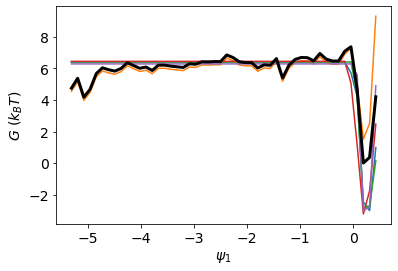

In [54]:
# plotting full and block PMFs
fig, ax = plt.subplots()
for i in range(n_blocks):
    ax.plot(bin_mids, pmf_MD_block[i])
im = ax.plot(bin_mids, pmf_MD, color='black', linewidth=3)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

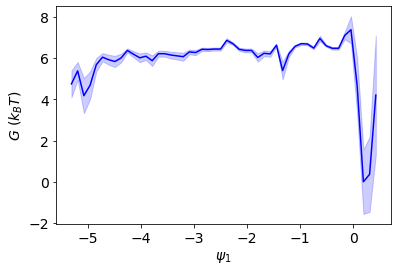

In [55]:
# plotting full PMFs with 95% CI (1.96 standard deviations in standard error)
fig, ax = plt.subplots()
ax.plot(bin_mids, pmf_MD, color='blue')
ax.fill_between(bin_mids, pmf_MD-1.96*pmf_MD_stderr, pmf_MD+1.96*pmf_MD_stderr, alpha=0.2, color='blue')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

In [56]:
# LSS 1D PMF mean
synth_trajs_CONCAT = np.zeros((0,))
for i in range(n_traj):
    synth_trajs_CONCAT = np.concatenate((synth_trajs_CONCAT,synth_trajs[i][:,0]), axis=0)
pdf_LSS, _ = np.histogram(synth_trajs_CONCAT, bins=n_bins, density=True)

pdf_LSS += 1./(len(synth_trajs_CONCAT)*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
pmf_LSS = -np.log(pdf_LSS)
pmf_LSS -= np.mean(pmf_LSS[np.isfinite(pmf_LSS)]) # optimal mutual least squares alignment

In [57]:
# LSS 1D PMF block averages
pmf_LSS_block = []
n_blocks=5
for i in range(n_blocks):
    
    data_i = np.array_split(synth_trajs_CONCAT,n_blocks,axis=0)[i] #block splits
    
    pdf_LSS_i, _ = np.histogram(data_i, bins=bin_edges, density=True)
    pdf_LSS_i += 1./(len(data_i)*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
    
    pmf_LSS_i = -np.log(pdf_LSS_i)
    pmf_LSS_i -= np.mean(pmf_LSS_i[np.isfinite(pmf_LSS_i)]) # optimal mutual least squares alignment
    pmf_LSS_block.append(pmf_LSS_i)
    
pmf_LSS_block = np.array(pmf_LSS_block)
pmf_LSS_stderr = np.std(pmf_LSS_block, axis=0)/np.sqrt(n_blocks)

In [58]:
# shifting global minimum to zero of optimally least squares aligned landscapes
PMF_shift = min(pmf_LSS)
pmf_LSS -= PMF_shift
for i in range(n_blocks):
    pmf_LSS_block[i] -= PMF_shift

[6.82199235 5.72338006 5.43569798 5.43569798 5.2125581  5.11724425
 5.56922938 5.31791495 6.12884516 5.90570161 5.31791495 5.56923112
 5.72338006 5.72338006 5.90570161 6.12884669 5.72338006 5.56922938
 5.03023288 5.31791495 5.43569977 5.21255443 5.56922938 5.56922938
 5.90570324 6.12884516 5.90570161 6.41652724 6.41652792 6.12884593
 6.41652724 7.51513953 6.82199285 7.51513953 6.12884593 7.51513953
 6.12884593 7.51513953 6.8219926  7.51513953 6.8219926  5.56922981
 6.12884536 5.90570202 6.12884555 5.31791534 3.54484805 0.49942749
 1.06625064 6.41652758]


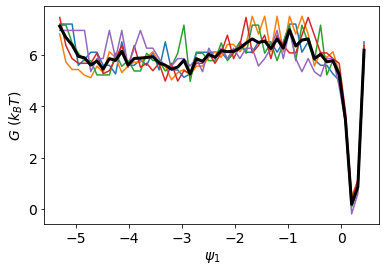

In [59]:
x = np.zeros(len(pmf_LSS_block[0]))
fig, ax = plt.subplots()
for i in range(n_blocks):
    x += pmf_LSS_block[i]/n_blocks
    ax.plot(bin_mids, pmf_LSS_block[i])
im = ax.plot(bin_mids, x, color='black', linewidth=3)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show
print(pmf_LSS_block[1])
pmf_LSS = x

<function matplotlib.pyplot.show(*args, **kw)>

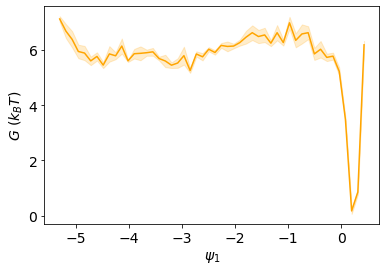

In [60]:
fig, ax = plt.subplots()
ax.plot(bin_mids, pmf_LSS, color='orange')
ax.fill_between(bin_mids, pmf_LSS-pmf_LSS_stderr, pmf_LSS+pmf_LSS_stderr, alpha=0.2, color='orange')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

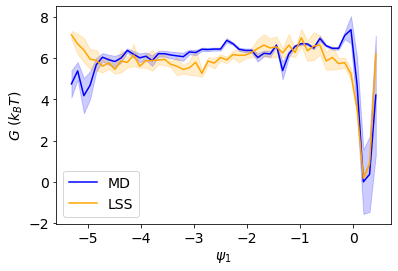

In [61]:
fig, ax = plt.subplots()
ax.plot(bin_mids, pmf_MD, color='blue', label='MD')
ax.fill_between(bin_mids, pmf_MD-1.96*pmf_MD_stderr, pmf_MD+1.96*pmf_MD_stderr, alpha=0.2, color='blue')
ax.plot(bin_mids, pmf_LSS, color='orange', label='LSS')
ax.fill_between(bin_mids, pmf_LSS-1.96*pmf_LSS_stderr, pmf_LSS+1.96*pmf_LSS_stderr, alpha=0.2, color='orange')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
ax.legend()
plt.show

<h3> $\psi_2$ thermo </h3>

In [62]:
# MD 1D PMF mean
psi_index = 1
n_bins = 50
pdf_MD, bin_edges = np.histogram(hde_coords[:,psi_index], bins=n_bins, density=True)
bin_mids = bin_edges[:-1]+0.5*(bin_edges[1]-bin_edges[0])

pdf_MD += 1./(len(hde_coords[:,psi_index])*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
pmf_MD = -np.log(pdf_MD)
pmf_MD -= np.mean(pmf_MD[np.isfinite(pmf_MD)]) # optimal mutual least squares alignment

In [63]:
# MD 1D PMF block averages
pmf_MD_block = []
n_blocks=5
for i in range(n_blocks):
    
    data_i = np.array_split(hde_coords[:,psi_index],n_blocks,axis=0)[i] #block splits
    
    pdf_MD_i, _ = np.histogram(data_i, bins=bin_edges, density=True)
    pdf_MD_i += 1./(len(data_i)*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
    
    pmf_MD_i = -np.log(pdf_MD_i)
    pmf_MD_i -= np.mean(pmf_MD_i[np.isfinite(pmf_MD_i)]) # optimal mutual least squares alignment
    pmf_MD_block.append(pmf_MD_i)
    
pmf_MD_block = np.array(pmf_MD_block)
pmf_MD_stderr = np.std(pmf_MD_block, axis=0)/np.sqrt(n_blocks)

In [64]:
# shifting global minimum to zero of optimally least squares aligned landscapes
PMF_shift = min(pmf_MD)
pmf_MD -= PMF_shift
for i in range(n_blocks):
    pmf_MD_block[i] -= PMF_shift

### kinetic (relaxation times)

In [ ]:
def compute_autocorr_time(signal, delays):
    ac=[]
    for j in delays:
        if type(signal) is list:
            z = np.concatenate([item[:] for item in signal])
            x = np.concatenate([item[:-j] for item in signal])
            y = np.concatenate([item[j:] for item in signal])
        else:
            z = signal[:]
            x = signal[:-j]
            y = signal[j:]
        ac.append(np.mean(x*y, axis=0)/np.mean(z*z, axis=0))
    return np.array(ac)

In [76]:
# MD mean autocorrelation and implied relaxation time
ac_MD = compute_autocorr_time(hde_coords[:,:dim_prop], [lag_prop])
relax_MD = -lag_prop/np.log(ac_MD)*timestep/1E3
print(ac_MD)


[[0.9992804  0.99654543 0.99582225 0.99518085 0.99203044 0.99155724
  0.9879049  0.9881073  0.9871661  0.9876998  0.9850577  0.9857674
  0.98384905 0.9812616  0.9857442  0.9815117  0.9835465  0.9776421
  0.9772265  0.97612286 0.98057777 0.9754676  0.9715807  0.9685498
  0.96873105 0.96922493 0.96465653 0.96694106 0.9516658  0.91022587]]


In [77]:
# MD block average standard error estimate
ac_MD_block = []
n_blocks=5
for i in range(n_blocks):
    ac_MD_i = compute_autocorr_time(np.array_split(hde_coords[:,:dim_prop],n_blocks,axis=0)[i], [lag_prop])
    ac_MD_block.append(ac_MD_i)
ac_MD_block = np.array(ac_MD_block)
ac_MD_block = ac_MD_block.reshape(n_blocks,dim_prop)

relax_MD_block = -lag_prop/np.log(ac_MD_block)*timestep/1E3
relax_MD_stderr = np.std(relax_MD_block, axis=0)/np.sqrt(n_blocks)

In [78]:
print('MD relaxation times (ns) = ')
for i in range(relax_MD.shape[1]):
    print('%f +/- %f' % (relax_MD[0,i], relax_MD_stderr[i]))

MD relaxation times (ns) = 
13891.476562 +/- 1689.519409
2889.716797 +/- 1720.731201
2388.629883 +/- 1111.956665
2070.048584 +/- 600.925476
1249.768066 +/- 135.797180
1179.439819 +/- 410.765656
821.771362 +/- 157.055328
835.843628 +/- 109.876930
774.176025 +/- 55.080242
807.985046 +/- 205.390228
664.229004 +/- 111.552177
697.601562 +/- 134.200912
614.145020 +/- 151.984924
528.648071 +/- 74.189514
696.455811 +/- 121.416183
535.867371 +/- 149.473434
602.759399 +/- 106.604858
442.250732 +/- 80.513008
434.087555 +/- 63.489140
413.790436 +/- 87.634567
509.857483 +/- 109.886131
402.603882 +/- 72.326927
346.849335 +/- 47.070572
312.936218 +/- 47.256760
314.779572 +/- 50.481102
319.912292 +/- 59.257767
277.907715 +/- 18.842987
297.462006 +/- 25.865047
201.851639 +/- 24.066320
106.312286 +/- 17.412729


In [79]:
# LSS mean autocorrelation and implied relaxation time
ac_LSS = compute_autocorr_time(synth_trajs, [1])
relax_LSS = -lag_prop/np.log(ac_LSS)*timestep/1E3
print(ac_LSS)


[[0.71899164 0.6303109  0.24692328 0.28231174 0.67924637 0.60212666
  0.25754336 0.29594707 0.6907997  0.35611188 0.4545604  0.23552622
  0.29149845 0.53812313 0.6656361  0.35414603 0.16648474 0.29869264
  0.4801374  0.30649984 0.5878328  0.17612429 0.6501077  0.29556736
  0.31149885 0.3602999  0.5998332  0.6235724  0.7370474  0.40377343]]


In [80]:
# LSS block average standard error estimate
# N.B. Blocks in this case are over complete indepenent LSS trajectories since data must be continuous

assert n_traj >= 5 # need at least 5 independent trajectories for reasonable blocks

ac_LSS_block = []
for i in range(n_traj):
    ac_LSS_i = compute_autocorr_time(synth_trajs[i], [1])
    ac_LSS_block.append(ac_LSS_i)
ac_LSS_block = np.array(ac_LSS_block)
ac_LSS_block = ac_LSS_block.reshape(n_traj,synth_trajs[0].shape[1])

relax_LSS_block = -lag_prop/np.log(ac_LSS_block)*timestep/1E3
relax_LSS_stderr = np.std(relax_LSS_block, axis=0)/np.sqrt(n_traj)

In [81]:
print('LSS relaxation times (ns) = ')
for i in range(relax_LSS.shape[1]):
    print('%f +/- %f' % (relax_LSS[0,i], relax_LSS_stderr[i]))

LSS relaxation times (ns) = 
30.311707 +/- 3.092845
21.666496 +/- 2.730757
7.149611 +/- 0.478096
7.906743 +/- 0.448622
25.855066 +/- 0.407535
19.712690 +/- 5.336890
7.371548 +/- 0.388823
8.213049 +/- 0.235752
27.033941 +/- 0.231523
9.685134 +/- 0.521706
12.683522 +/- 0.481391
6.915950 +/- 0.434065
8.112138 +/- 0.539084
16.137676 +/- 1.354432
24.569290 +/- 4.773278
9.633486 +/- 0.486395
5.577706 +/- 0.466175
8.275815 +/- 0.308744
13.629867 +/- 0.617977
8.456388 +/- 0.092650
18.821306 +/- 3.907637
5.758493 +/- 0.282316
23.222479 +/- 0.863346
8.204397 +/- 0.204703
8.573685 +/- 0.299755
9.796061 +/- 0.339868
19.565502 +/- 2.291889
21.173414 +/- 2.761843
32.775803 +/- 1.236500
11.026558 +/- 0.622356


### structure (RMSD)

In [72]:
#xyz_synth = xyz_scaler.inverse_transform(molgen.transform(synth_trajs_scaled[synth_traj_id])).reshape(-1, n_atoms, 3)

In [73]:
def writeToXYZ(xyz_coordinates, filename):
    with open(filename, 'w') as f:
        for i in range(xyz_coordinates.shape[0]):
            f.write('%d\n' % n_atoms)
            f.write('\n')
            for k in range(n_atoms):
                f.write('%3s%17.9f%17.9f%17.9f\n' % ('C', xyz_synth[i][k][0]*10, xyz_synth[i][k][1]*10, xyz_synth[i][k][2]*10) ) # nm to Angstroms for xyz write

                
def xyzToTraj(xyz_coordinates,fn="temp.xyz"):
    writeToXYZ(xyz_coordinates, fn)
    traj = md.load(fn, top='synth.pdb')
    return traj

In [74]:
'''
    ~~~RMSD Calculation~~~
    k = frames where the indexed LSS trajectory is in the metastable basin1
    l = frames where the MD obj trajectory is in the mestable basin1
    
    n = frames where the indexed LSS trajectory is in the metastable basin2
    m = frames where the MD obj trajectory is in the mestable basin2

    t = traj containing all corresponding LSS frames for basin 1
    s = traj containing all corresponding LSS frames for basin 2
    
'''
lowerBasin1 = -1.9
upperBasin1 = -1.5

lowerBasin2 = 0.5
upperBasin2 = 0.9


l = np.where(np.logical_and(hde_coords[:,0]>=lowerBasin1, hde_coords[:,0]<=upperBasin1))
m = np.where(np.logical_and(hde_coords[:,0]>=lowerBasin2, hde_coords[:,0]<=upperBasin2))


for i in range(len(synth_trajs)):
    print("Finding Frames for Traj ",i)
    k = np.where(np.logical_and(synth_trajs[i][:,0]>=lowerBasin1, synth_trajs[0][:,0]<=upperBasin1))
    n = np.where(np.logical_and(synth_trajs[i][:,0]>=lowerBasin2, synth_trajs[0][:,0]<=upperBasin2))
    xyzi = xyz_scaler.inverse_transform(molgen.transform(synth_trajs_scaled[i])).reshape(-1, n_atoms, 3)
    if(i == 0): t = xyzToTraj(xyzi)[k]
    else: t = md.join([t,xyzToTraj(xyzi)[k]])
    if(i == 0): s = xyzToTraj(xyzi)[n]
    else: s = md.join([t,xyzToTraj(xyzi)[n]])

Finding Frames for Traj  0
Finding Frames for Traj  1
Finding Frames for Traj  2
Finding Frames for Traj  3
Finding Frames for Traj  4


In [75]:
rmsd1 = np.mean(md.rmsd(t, traj_ca[l]))
rmsd2 = np.mean(md.rmsd(s, traj_ca[m]))
print("Basin One RMSD is ", rmsd1, " nm. Found ", len(t), "LSS frames in Basin One and ", len(l[0]), " MD frames")
print("Basin Two RMSD is ", rmsd2, " nm. Found ", len(s), "LSS frames in Basin Two and ", len(m[0]), " MD frames")

ValueError: Cannot calculate RMSD of frame 0: reference has only 0 frames.

In [ ]:
np.where(np.logical_and(hde_coords[:,0]>=lowerBasin2, hde_coords[:,0]<=upperBasin2))

In [ ]:
67734/23695